# Imports

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from haversine import haversine
from itertools import izip

# Load Data

In [102]:
column_names = [
    "lat", 
    "lon", 
    "id", 
    "source_id", 
    "account_id", 
    "title", 
    "created_on", 
    "updated_on", 
    "start_ts", 
    "until_ts",
    "report_type",
    "notes", 
    "layer_id",
    "severity"
]

target_columns = [
    "lat",
    "lon",
    "title",
    "created_on",
    "start_ts",
    "severity"
]

In [103]:
# Load training dataset
df = pd.read_table("data/reports_12DEC16-26DEC16.txt", header=None, names=column_names)

# Drop rows with NaNs (this is admittedly ugly and the final model will be much more precise)
df.dropna(axis=0, how="any", inplace=True)

# Drop columns we won't need
df = df[target_columns]

# Convert timestamps from Unix Epoch time to Date Time Groups
df["created_on"] = pd.to_datetime(df["created_on"], unit="s", errors="ignore")
df["start_ts"] = pd.to_datetime(df["start_ts"], unit="s", errors="ignore")


In [104]:
print df.info()
# print df.describe()
# print df.head()
# print df.tail()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98996 entries, 0 to 127327
Data columns (total 6 columns):
lat           98996 non-null float64
lon           98996 non-null float64
title         98996 non-null object
created_on    98996 non-null datetime64[ns]
start_ts      98996 non-null datetime64[ns]
severity      98996 non-null object
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 5.3+ MB
None


# Location

Will need to investigate haversine distance (from pip install haversine) and use that to map cities data from GeoNames to this dataset.

In [105]:
location_df = df[["lat", "lon"]]
location_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98996 entries, 0 to 127327
Data columns (total 2 columns):
lat    98996 non-null float64
lon    98996 non-null float64
dtypes: float64(2)
memory usage: 2.3 MB


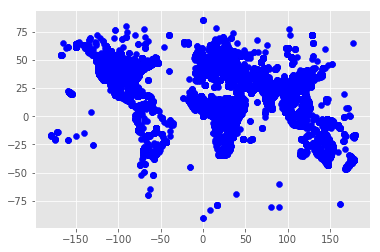

In [106]:
plt.scatter(location_df["lon"], location_df["lat"], color="b")


## Label reports with cities using GeoNames Cities15000 dataset

I explored running a clustering algorithm on the risk reports data to see if it could help define regions I could use for more granular risk thresholds. I used a k Nearest Neighbors model and concluded that k ~= 1000 was ideal. That led me to explore labeling reports to their closest city, and then picking a couple of cities to explore in more depth. 

GeoNames provides a large number of datasets for geolocation, including several for cities around the world (http://download.geonames.org/export/dump/). Cities15000 includes all cities of 15,000 or more and includes a population column. We'll use that to trim down to about 1400 cities by selecting cities of only 300,000 or more.

In [107]:
# Cities15000 column names
city_columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature_class",
    "feature_code",
    "country_code",
    "cc2",
    "admin1_code",
    "admin2_code", 
    "admin3_code",
    "admin4_code",
    "population", 
    "elevation",
    "dem",
    "timezone",
    "modification_date",
]

target_city_columns = [
    "name",
    "latitude",
    "longitude",
    "country_code",
]

In [108]:
# Load Cities15000 dataset
cities_df = pd.read_table("data/cities15000.txt", header=None, names=city_columns)

# Select only medium and larger sized cities and reindex
cities_df = cities_df[cities_df["population"] > 300000]
cities_df = cities_df.reset_index()

# Select only the columns we'll need to label our reports dataset
cities_df = cities_df[target_city_columns]


print cities_df.info()
print cities_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 4 columns):
name            1375 non-null object
latitude        1375 non-null float64
longitude       1375 non-null float64
country_code    1375 non-null object
dtypes: float64(2), object(2)
memory usage: 43.0+ KB
None
             name  latitude  longitude country_code
0           Dubai  25.06570   55.17128           AE
1         Sharjah  25.33737   55.41206           AE
2          Al Ain  24.19167   55.76056           AE
3       Abu Dhabi  24.46667   54.36667           AE
4  Mazār-e Sharīf  36.70904   67.11087           AF


### Compute Haversine Distances

Now that we've got that data cleaned up we can start working on labeling the time series data. The first thing to consider is how we'll actually label the cities. The best way to do this is to calculate the haversine distances (https://en.wikipedia.org/wiki/Haversine_formula) from each report to each city, and label that report with the city with the smallest haversine distance. 

The haversine formula installed by pip takes takes two tuples of lat/long pairs and returns the distance in kilometers between those two points. We'll need to make sure we have an extra column to store latitude and longitude as tuples in each dataframe, so let's do that now.

In [109]:
df["lat_long"] = zip(df["lat"], df["lon"])
cities_df["lat_long"] = zip(cities_df["latitude"], cities_df["longitude"])

print df.head()
print
print cities_df.head()

         lat        lon                                              title  \
0  37.983810  23.727539  Security Message for U.S. Citizens: Athens (Gr...   
1  17.570692  -3.996166  Security Message for U.S. Citizens: Bamako (Ma...   
2  -4.441931  15.266293  Security Message for U.S. Citizens: Kinshasa (...   
3   7.369722  12.354722  Security Message for U.S. Citizens: Yaounde (C...   
4  18.594395 -72.307433  Security Message for U.S. Citizens: Port-au-Pr...   

  created_on            start_ts severity                  lat_long  
0 2016-12-15 2016-11-14 14:12:50  unrated  (37.9838096, 23.7275388)  
1 2016-12-19 2016-11-18 18:10:19  unrated    (17.570692, -3.996166)  
2 2016-12-19 2016-11-18 18:10:24  unrated  (-4.4419311, 15.2662931)  
3 2016-12-19 2016-11-18 22:10:19  unrated     (7.369722, 12.354722)  
4 2016-12-22 2016-11-21 21:10:29  unrated  (18.594395, -72.3074326)  

             name  latitude  longitude country_code              lat_long
0           Dubai  25.06570   55.171

### Apply Labels

Easy enough. Now for the labeling. The next cell is brute force caclulating about 1 billion haversine distances and will take quite some time to run. I've saved the indices to a csv file for convenience.

In [110]:
# Build a series of indices of shortest haversine distances. Skip to the next cell to save time.
# city_label_indices = []
# for report in df["lat_long"]:
#     distances = [haversine(report, city) for city in cities_df["lat_long"]]
#     city_label_indices.append(np.argmin(distances))

In [111]:
# Quick import of the result from the cell above
city_label_indices = pd.read_csv("data/city_label_indices.csv", header=None)
city_label_indices = city_label_indices[1].values

In [112]:
# Generate city labels from our indices
city_labels = []
for index in city_label_indices:
    city_labels.append(cities_df.ix[index, "name"])

/Users/brendandorsey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [113]:
# Apply the labels to our reports
df["city"] = city_labels
print df.head()

         lat        lon                                              title  \
0  37.983810  23.727539  Security Message for U.S. Citizens: Athens (Gr...   
1  17.570692  -3.996166  Security Message for U.S. Citizens: Bamako (Ma...   
2  -4.441931  15.266293  Security Message for U.S. Citizens: Kinshasa (...   
3   7.369722  12.354722  Security Message for U.S. Citizens: Yaounde (C...   
4  18.594395 -72.307433  Security Message for U.S. Citizens: Port-au-Pr...   

  created_on            start_ts severity                  lat_long  \
0 2016-12-15 2016-11-14 14:12:50  unrated  (37.9838096, 23.7275388)   
1 2016-12-19 2016-11-18 18:10:19  unrated    (17.570692, -3.996166)   
2 2016-12-19 2016-11-18 18:10:24  unrated  (-4.4419311, 15.2662931)   
3 2016-12-19 2016-11-18 22:10:19  unrated     (7.369722, 12.354722)   
4 2016-12-22 2016-11-21 21:10:29  unrated  (18.594395, -72.3074326)   

          city  
0       Athens  
1  Ouagadougou  
2     Kinshasa  
3       Garoua  
4    Delmas 73  


And we're set! We'll be looking at a couple of European cities through the rest of this exploration (Berlin, Paris, and London).

## Time Series Exploration (Berlin)

This time series is centered on the Berlin market attack of 19 1902 DEC 2016 (UTC). The goal of the project is to detect likely incidents through anomolies in reporting as quickly as possible so Stabilitas customers can take appropriate action to stay safe. So let's see what the time series looks like for Berlin over this two week period.

In [114]:
attack_dtg = "2016-12-19 19:02:00"

In [115]:
berlin_df = df[df["city"] == "Berlin"]

print berlin_df.head()
print berlin_df.info()

           lat       lon                                              title  \
628   52.52437  13.41053   Berlin Borough prepping for planned power outage   
1027  52.52437  13.41053  Truck runs into crowded Christmas market in Be...   
1087  52.52437  13.41053  9 killed, 50 injured in Berlin in apparent tru...   
1124  52.52437  13.41053  Truck terror strikes Germany and European tourism   
1133  52.52437  13.41053  Truck crashed into Berlin market ‘intentionall...   

              created_on            start_ts  severity              lat_long  \
628  2016-12-16 05:08:54 2016-12-16 05:08:43  moderate  (52.52437, 13.41053)   
1027 2016-12-20 00:06:27 2016-12-20 00:06:15    medium  (52.52437, 13.41053)   
1087 2016-12-20 16:11:41 2016-12-20 16:11:30  moderate  (52.52437, 13.41053)   
1124 2016-12-20 23:07:32 2016-12-20 23:07:20  moderate  (52.52437, 13.41053)   
1133 2016-12-20 23:09:07 2016-12-20 23:08:56  moderate  (52.52437, 13.41053)   

        city  
628   Berlin  
1027  Berlin  

In [116]:
start_timeseries = pd.Series(np.ones(len(df))).reindex(berlin_df["start_ts"], fill_value=1)
ts = start_timeseries["2016-12-12":"2016-12-27"]


In [117]:
daily = ts.resample("d").sum()
hourly = ts.resample("H").sum()
five_mins = ts.resample("5T").sum()
weekly = ts.resample("7d").sum()

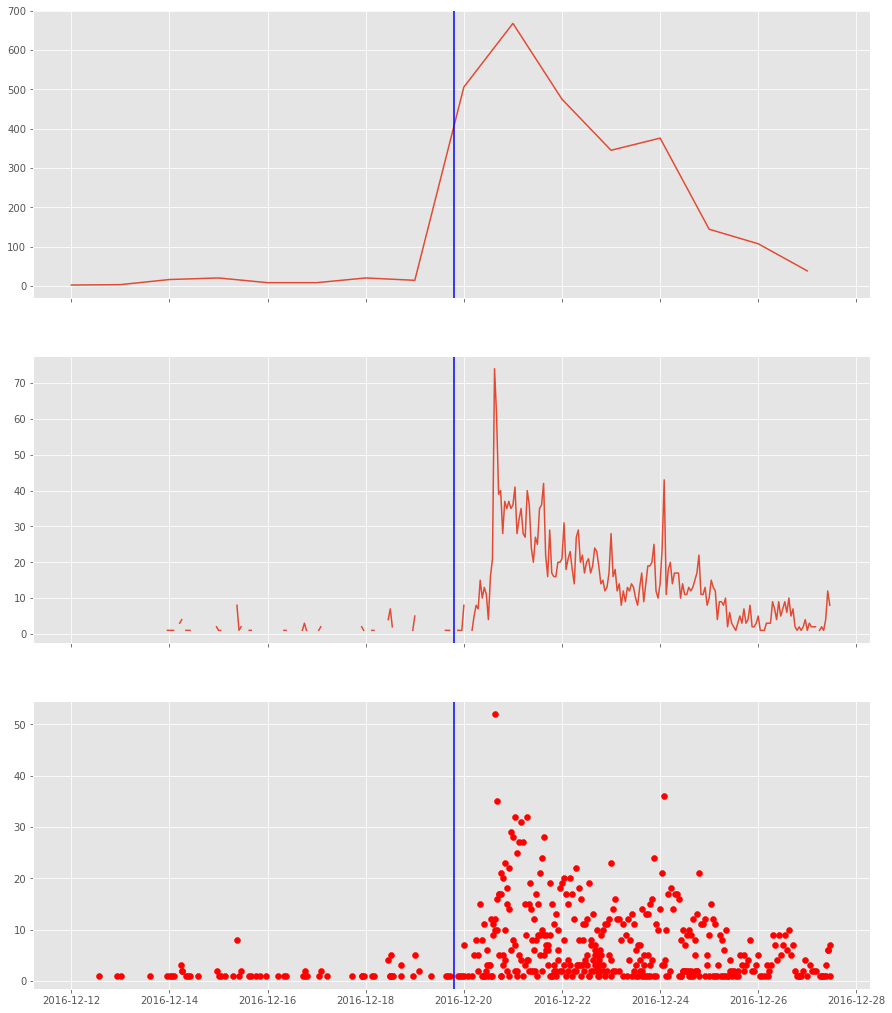

In [118]:
fig, axes = plt.subplots(3, figsize=(15,18), sharex=True)
axes[0].plot(daily)
axes[0].axvline(attack_dtg, color="b")
axes[1].plot(hourly)
axes[1].axvline(attack_dtg, color="b")
axes[2].scatter(five_mins.index, five_mins.values, color="r")
axes[2].axvline(attack_dtg, color="b")

Seems like Berlin was pretty quiet leading up to the attack. Let's look at the 19th and 20th a little more closely.

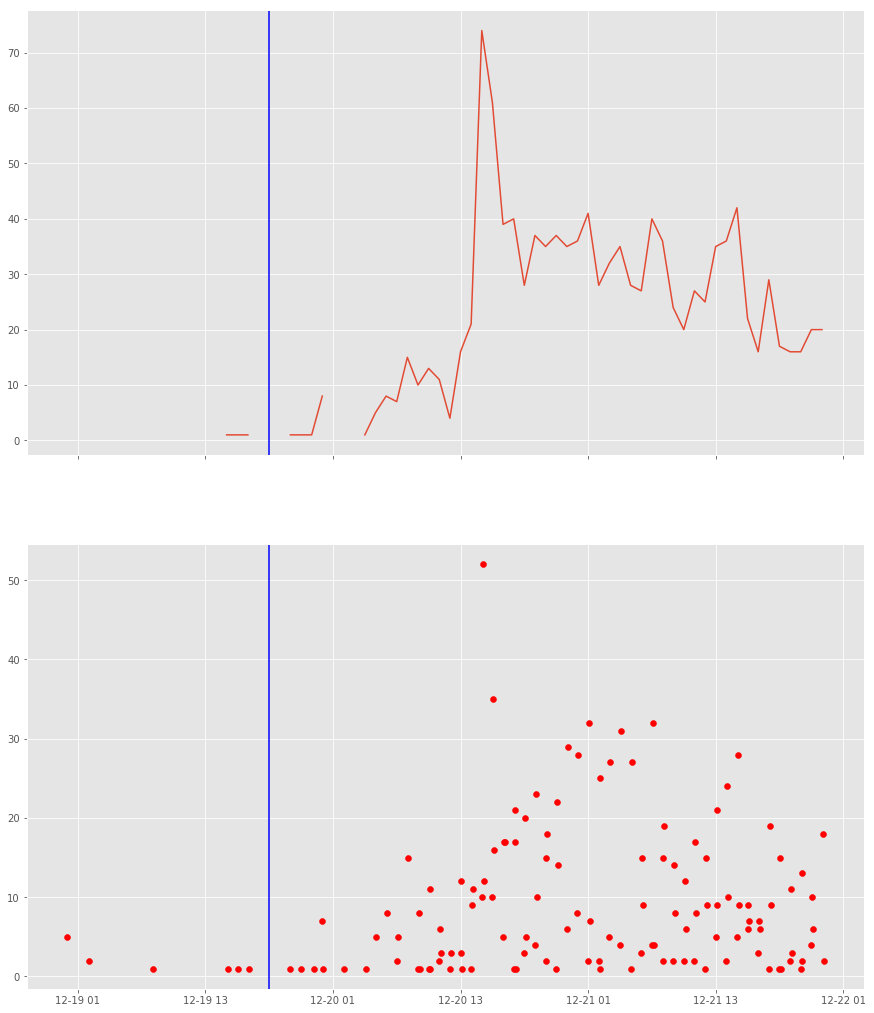

In [119]:
two_day = start_timeseries["2016-12-19":"2016-12-21"]

td_daily = two_day.resample("d").sum()
td_hourly = two_day.resample("H").sum()
td_five_mins = two_day.resample("5T").sum()
fig, axes = plt.subplots(2, figsize=(15,18), sharex=True)

axes[0].plot(td_hourly)
axes[1].scatter(td_five_mins.index, td_five_mins.values, color="r")
axes[0].axvline(attack_dtg, color="b")
axes[1].axvline(attack_dtg, color="b")

That first blip after the attack is where I'd like to be able to detect that something serious has happened. Now that we can see there's a blip there before the giant spike from the next day, let's see what we can do to pull that out from the random noise.

At this point it's may be helpful for a quick aside to see why I'm plotting the 5-minute volumes. Below I've plotted the data over the entire two weeks across a range of resampling intervals

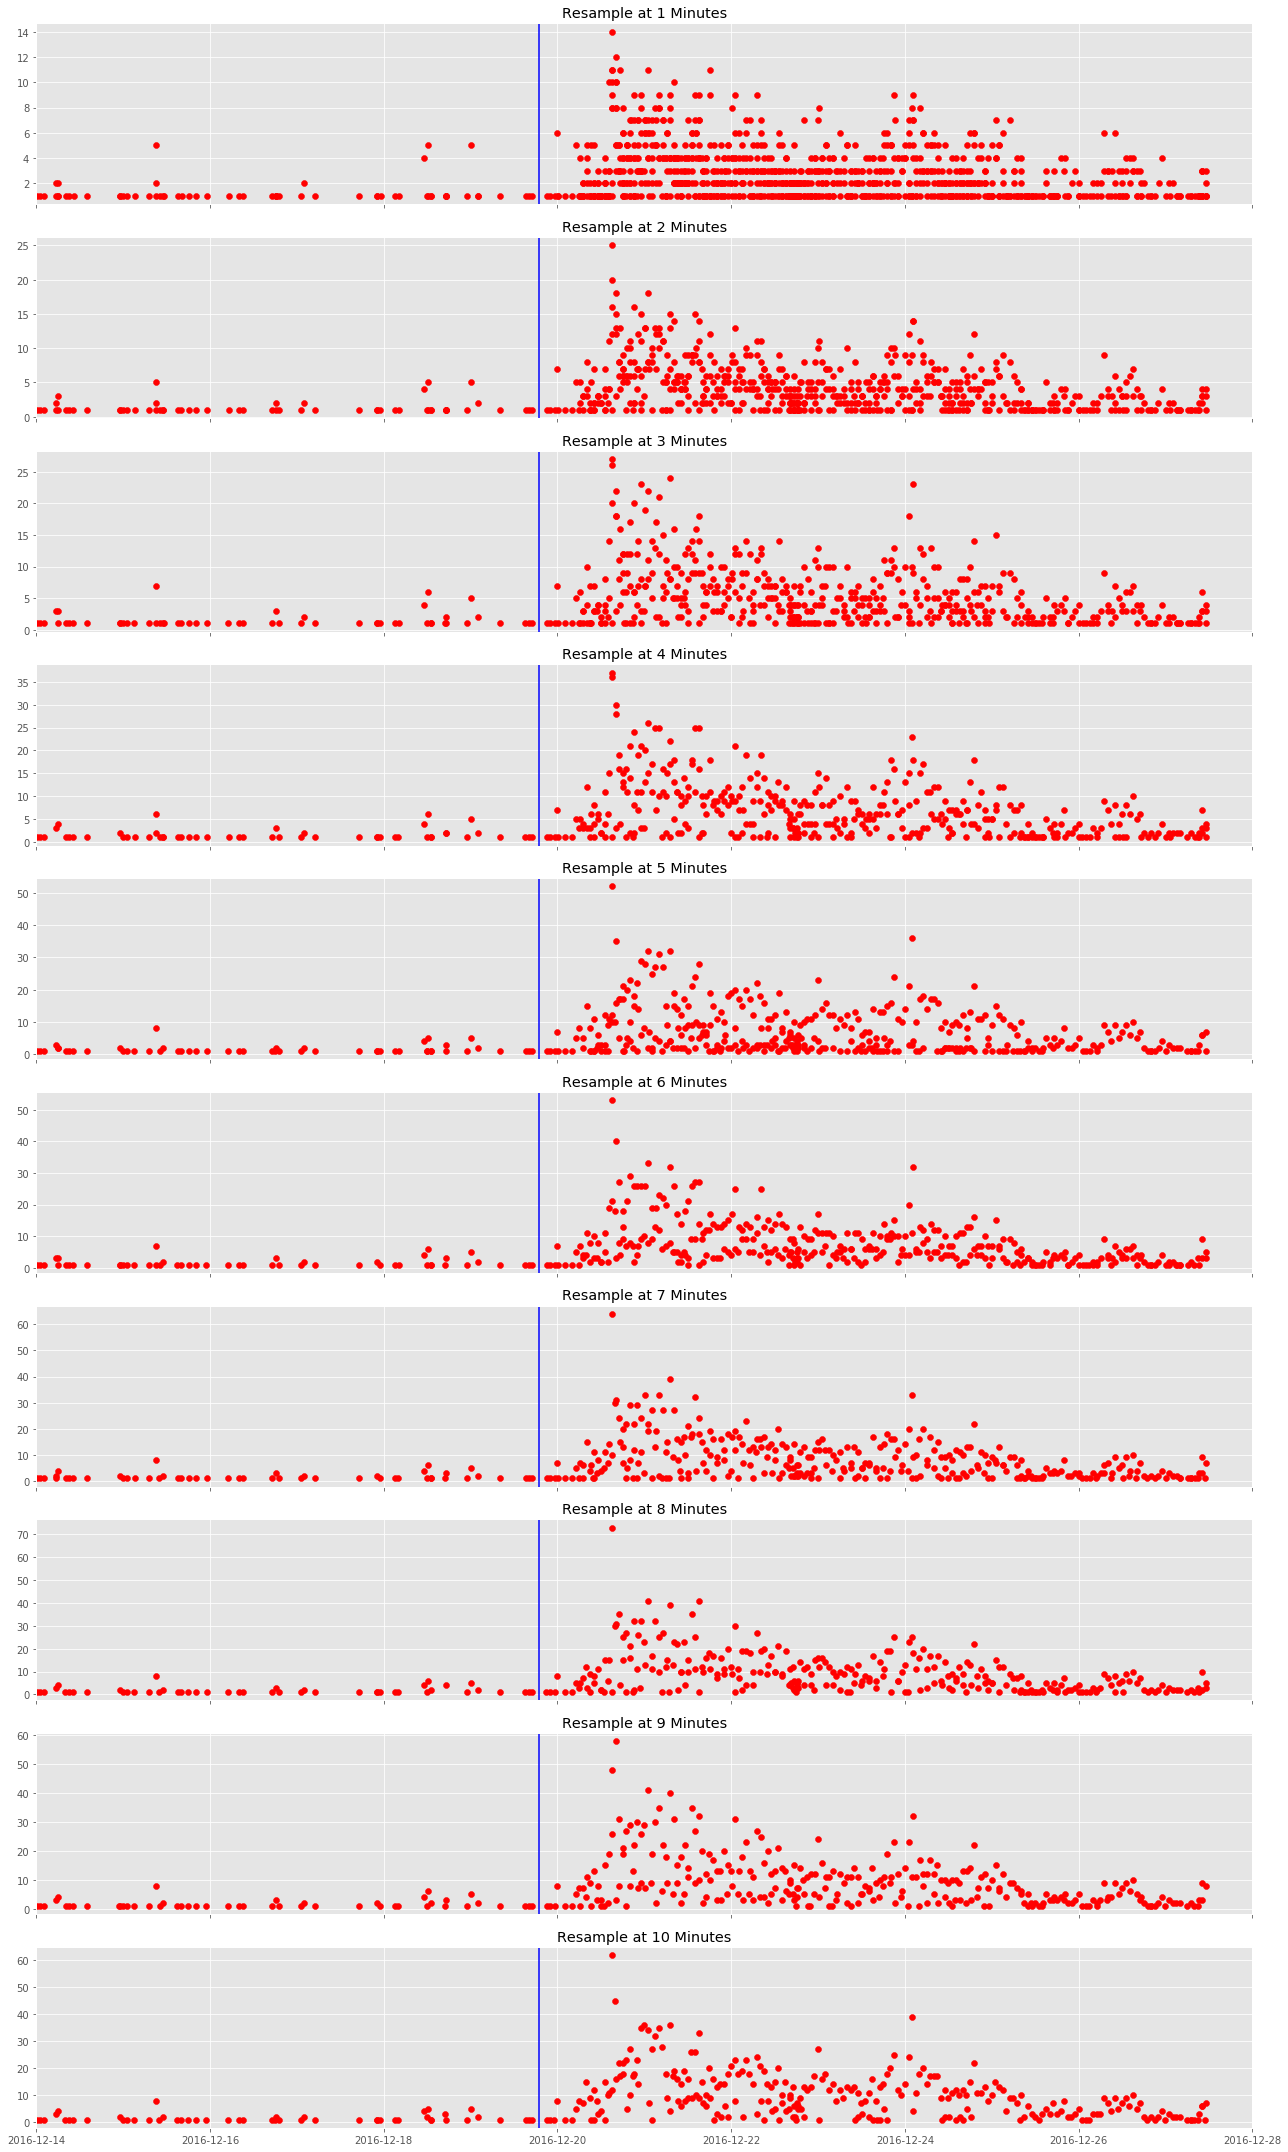

In [120]:
fig, axes = plt.subplots(10, figsize=(18,30), sharex=True)
for i, ax in enumerate(axes.flatten()):
    sampler = ts.resample("{}T".format(i+1)).sum()
    ax.scatter(sampler.index, sampler.values, color="r")
    ax.set_title("Resample at {} Minutes".format(i+1))
    ax.axvline(attack_dtg, color="b")
    
plt.xlim("2016-12-14", "2016-12-28")
plt.tight_layout()

There's banding and a lot of noise for anything less than 5 minutes. Time intervals greater than 5 minutes improve the signal of extreme data, but timeliness is critical for this application. Tuning will be required to get this dialed in.

### Sidebar

Also of note, time series are usually plotted as lines, not scatter plots. This series has some gaps and a lot of variance, however, which combine to make scatter plots much more effective. Comparison below.

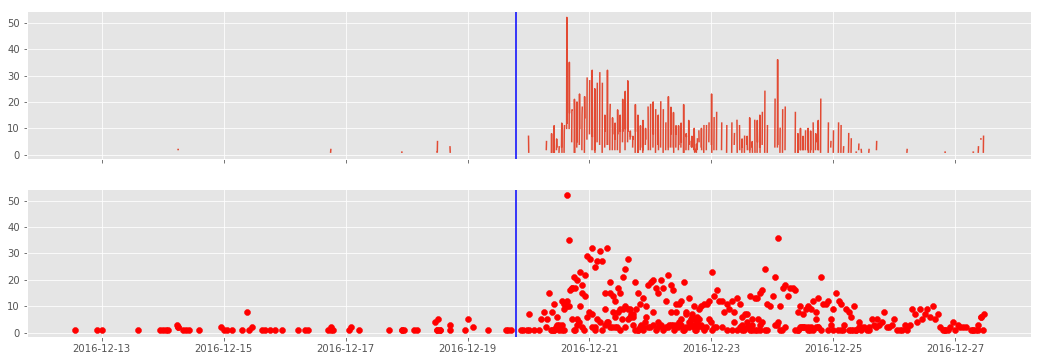

In [121]:
fig, axes = plt.subplots(2, figsize=(18,6), sharex=True)
# plt.title("Comparison of line and scatter plots, 10 minute resampling")
axes[0].plot(five_mins)
axes[0].axvline(attack_dtg, color="b")
axes[1].scatter(five_mins.index, five_mins.values, color="r")
axes[1].axvline(attack_dtg, color="b")

### Back to the time series

It seems like a timescale of 5-7 minutes is going to be ideal, so we'll focus on that and work with 5 minutes for now. Let's look at a moving average for our time series, as that will likely be our key to setting thresholds.

We'll start by comparing some different window sizes.

In [122]:
# This cell is adapted from a Galvanize lecture on time series.
# Credit to Matt Drury and Jack Benetto.

def fit_moving_average_trend(series, window=6):
    return series.rolling(window, min_periods=2, center=False).mean()



In [219]:
def fit_moving_average_trend(series, window=6):
    return series.rolling(window=window, min_periods=2, center=False).mean()

def fit_moving_std_trend(series, window=6):
    return series.rolling(window=window, min_periods=2, center=False).std()

def plot_moving_average_trend(ax, name, data_series, window=6):
    moving_average_trend = fit_moving_average_trend(data_series, window)
    ax.scatter(data_series.index, data_series.values, color="r")
    ax.plot(data_series.index, moving_average_trend, color="K", alpha=0.7)
    ax.set_title(name)

def plot_moving_std_trend(ax, name, data_series, window=6):
    moving_average_trend = fit_moving_average_trend(data_series, window)
    moving_std_trend = fit_moving_std_trend(data_series, window)
    ax.scatter(
        data_series.index, 
        data_series.values, 
        color="r"
    )
    ax.plot(
        data_series.index, 
        moving_average_trend, 
        color="K", 
        alpha=0.7)
    ax.fill_between(
        moving_average_trend.index, 
        moving_average_trend+moving_std_trend, 
        moving_average_trend-moving_std_trend, 
        color="K", alpha=0.3)
    
    ax.set_title(name)

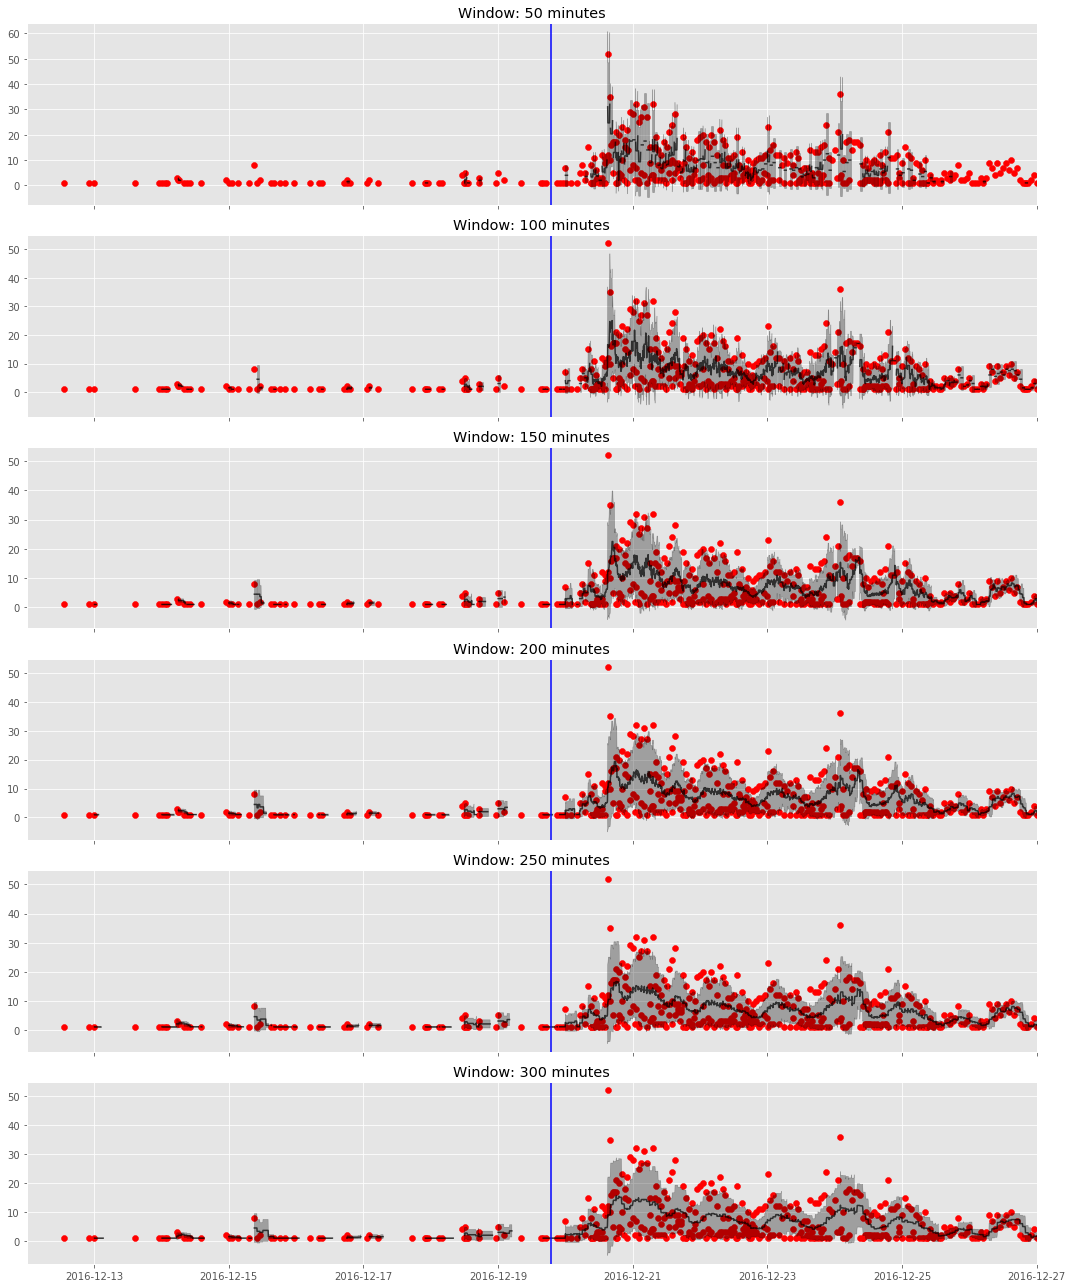

In [159]:
fig, axs = plt.subplots(6, figsize=(15,18), sharex=True)
for i, ax in enumerate(axs.flatten()):
    plot_moving_std_trend(ax, "Window: {} minutes".format((i+1)*10*5), five_mins, (i+1)*10)
    ax.axvline(attack_dtg, color="b")
plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

Let's see what that looks like with moving averages from on day and one week (we'll examine even longer periods later, but for now we've just got two weeks to work with.

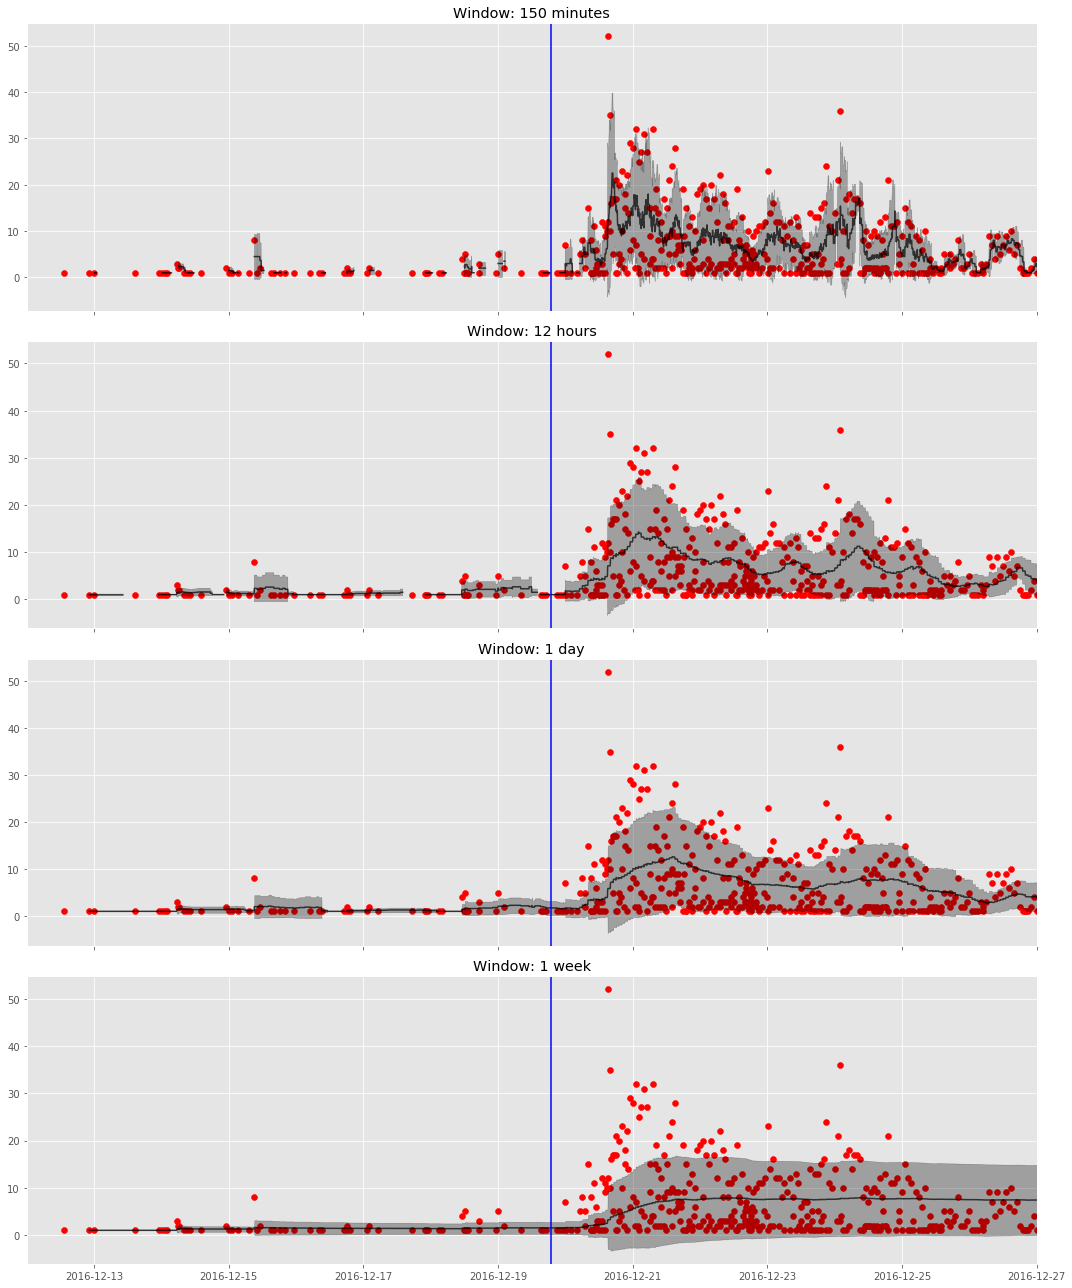

In [125]:
fig, axs = plt.subplots(4, figsize=(15,18), sharex=True)

plot_moving_std_trend(
    axs[0],
    name="Window: 150 minutes",
    data_series=five_mins,
    window=30
)
axs[0].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[1],
    name="Window: 12 hours",
    data_series=five_mins,
    window=144
)
axs[1].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[2],
    name="Window: 1 day",
    data_series=five_mins,
    window=288
)
axs[2].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[3],
    name="Window: 1 week",
    data_series=five_mins,
    window=288*7
)
axs[3].axvline(attack_dtg, color="b")

plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

Let's look at what's going on with the rolling standard deviation a bit more closely.

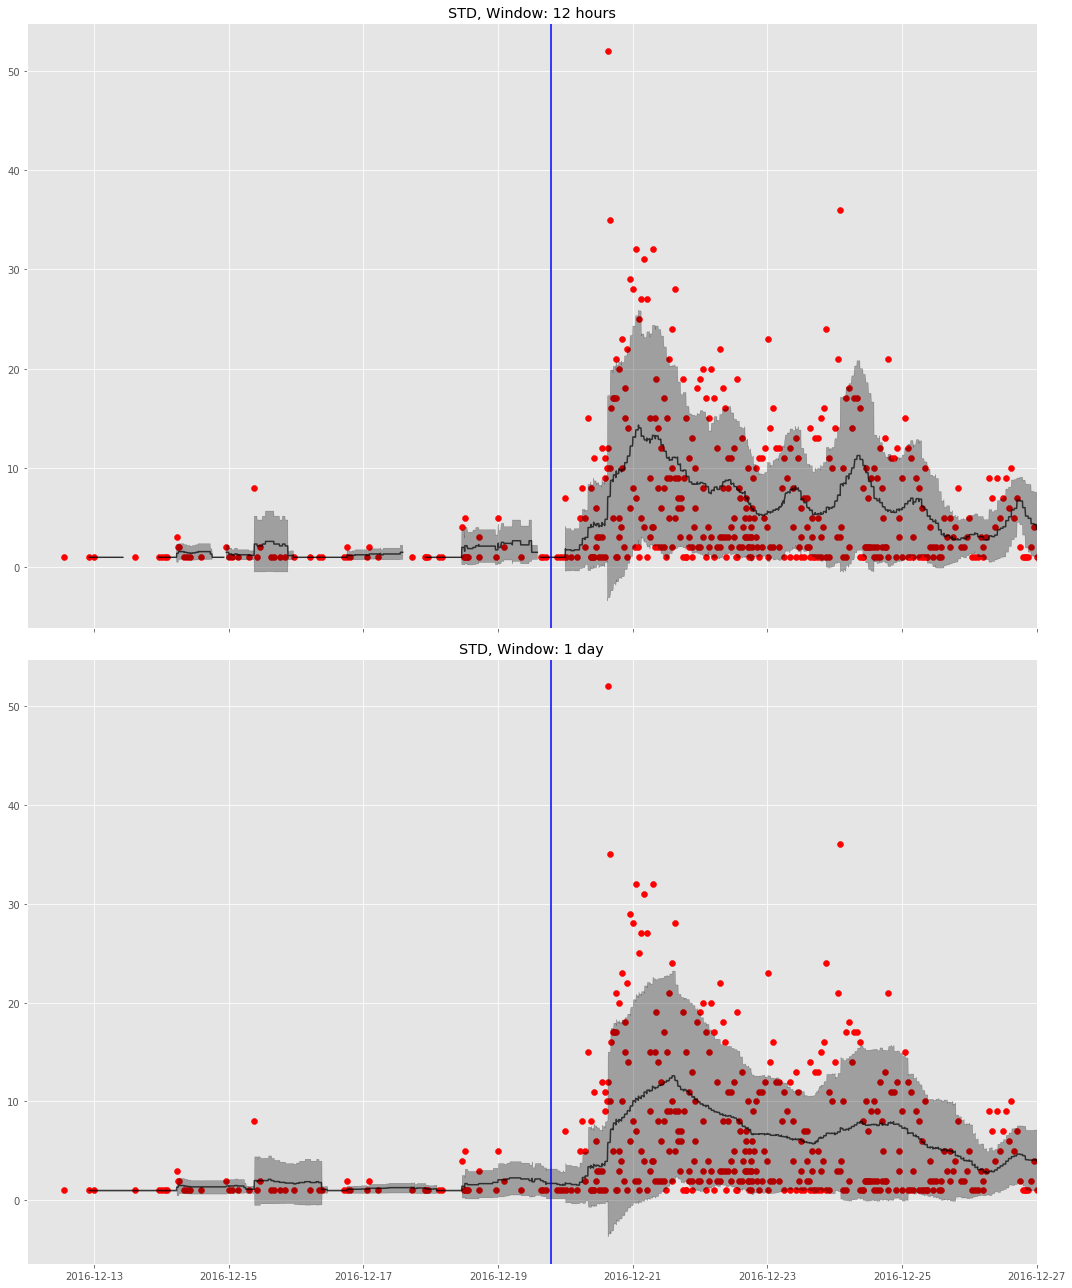

In [126]:
fig, axs = plt.subplots(2, figsize=(15,18), sharex=True)

plot_moving_std_trend(
    axs[0],
    name="STD, Window: 12 hours",
    data_series=five_mins,
    window=144
)
axs[0].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[1],
    name="STD, Window: 1 day",
    data_series=five_mins,
    window=288
)
axs[1].axvline(attack_dtg, color="b")

plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

There are some really useful things here. We can use our rolling standard deviation and mean as simple classifiers for elevated risk level. More importantly, we can use some more sophisticated techniques on the data from points that get flagged as elevated to predict the probability of much greater activity in the near future.

To be clear, this model would not be able to predict serious incidents themselves. Rather, it would use data from anomalous report volumes to calculate the porbability that those reports have come from a serious event.

# Conclusions from Initial EDA

We've looked at the data pretty thoroughly and at this point I think we know enough to move to some preliminary modeling. To review:

We'll proceed with a two-layered model. 

The first layer will flag any grouped datapoints that are one rolling standard deviation above the rolling mean as elevated risk. This flag should be persisted for a while once it's created, but that decision should include stakeholder and customer feedback. My sense is that 4-6 hours is about right.

The second layer will investigate the flagged reports. It will calculate the probability that each of the reports it investigates is indicative of a major event, like the Berlin attack we explored here. I don't have explicitly labeled data to train this model, but I think there are some efficient ways to work around that. 

In order to make this work, we need to prepare our data appropriately. This includes clustering reports to their nearest medium+ sized city and grouping them into useable time series. 

# Appendices

## K means clustering model

This unsupervised learning was intended to explore "regionality" of the risk data. Since I am not using this clustering to predict anything this will likely not play a role in the final model. Clustering based on location may be useful in a production model for other uses though.


I've evaluated each model by its silhouette score (https://en.wikipedia.org/wiki/Silhouette_(clustering)). Values range from -1 to 1, with higher values indicating that points are BOTH very similar to their own cluster AND dissimilar from their neighboring clusters.

##### The cell below takes a long time to run, so I've stored the scores resulting from the grid search for convenience

[0.623, 0.692, 0.831, 0.88]


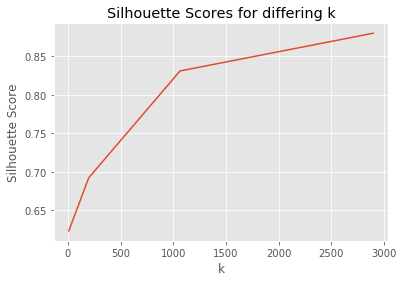

In [27]:
# Load lat/long pairs into numpy
X = location_df.values

# Split data and run on test set.
# The train set is too large to handle locally.
X_train, X_test = train_test_split(X)

# max_clusters = range(2, 21)
# best score from above at 2 (0.66), then at 7 (0.62)

# max_clusters = [100, 150, 200, 250, 300, 350, 400, 450, 500]
# best score from above at 500 (0.77)

# max_clusters = [2, 50, 100, 500, 1000, 5000]
# 5000 clusters takes a LONG time locally (~15 mins).
# Scores: 0.659, 0.535, 0.599, 0.773, 0.824, 0.872

# max_clusters = [600, 800, 1000, 1200, 1400]
# Scores: 0.789, 0.811, 0.827, 0.838, 0.846

# K = num continents, num countries, num cities 500k+, num cities 150k+
max_clusters = [7, 196, 1063, 2896]
# Scores: 0.623, 0.692, 0.831, 0.880
scores = [0.623, 0.692, 0.831, 0.880]

# scores = []
# for k in max_clusters:
#     print "Calculating with {} clusters...".format(k)
#     print "          ...fitting...          "
    
#     model = KMeans(n_clusters=k).fit(X_test)
#     print "          ...scoring...          "
    
#     score = silhouette_score(
#         X_test, 
#         model.predict(X_test), 
#         metric="euclidean"
#     )
    
#     scores.append(score)
#     print "{0} cluster silhouette score = {1}".format(k, score)

print scores

plt.plot(max_clusters, scores)
plt.title("Silhouette Scores for differing k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

### Grid Search results for k

From a grid search, exploratory perspective it seems k is optimal at around 1000, at least when evaluating by silhouette score. Optimizing to meet other criteria (e.g. a different score metric or to conform to real world situations) may yield different results. Below is the chart for silhouette scores from 2 to 5000 clusters.

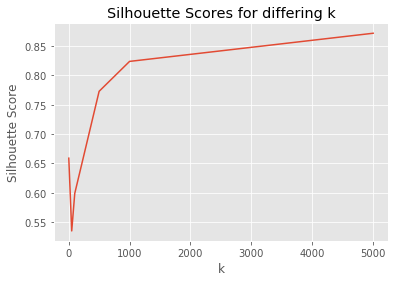

In [28]:
# Plot results from widest grid search
plt.plot(
    [2, 50, 100, 500, 1000, 5000], 
    [0.659, 0.535, 0.599, 0.773, 0.824, 0.872],
)
plt.title("Silhouette Scores for differing k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

## Time Series of the Global Data

Two candidates for time series work, created and start_ts. We will work with start_ts as that indicates the time the report will start being displayed on the Stabilitas app, but this compares the time series data from both

In [29]:
start_timeseries = pd.Series(np.ones(len(df))).reindex(
        pd.to_datetime(
            df["start_ts"], unit="s", errors="ignore"),
        fill_value=1
)
global_ts = start_timeseries["2016-12-12":"2016-12-27"]

create_timeseries = pd.Series(np.ones(len(df))).reindex(
        pd.to_datetime(
            df["created_on"].astype(int), unit="s", errors="ignore"),
        fill_value=1
)
global_c_ts = create_timeseries["2016-12-12":"2016-12-27"]

In [30]:
global_daily = global_ts.resample("d").sum()
global_hourly = global_ts.resample("H").sum()
global_ten_mins = global_ts.resample("10T").sum()

global_c_daily = global_c_ts.resample("d").sum()
global_c_hourly = global_c_ts.resample("H").sum()
global_c_ten_mins = global_c_ts.resample("10T").sum()

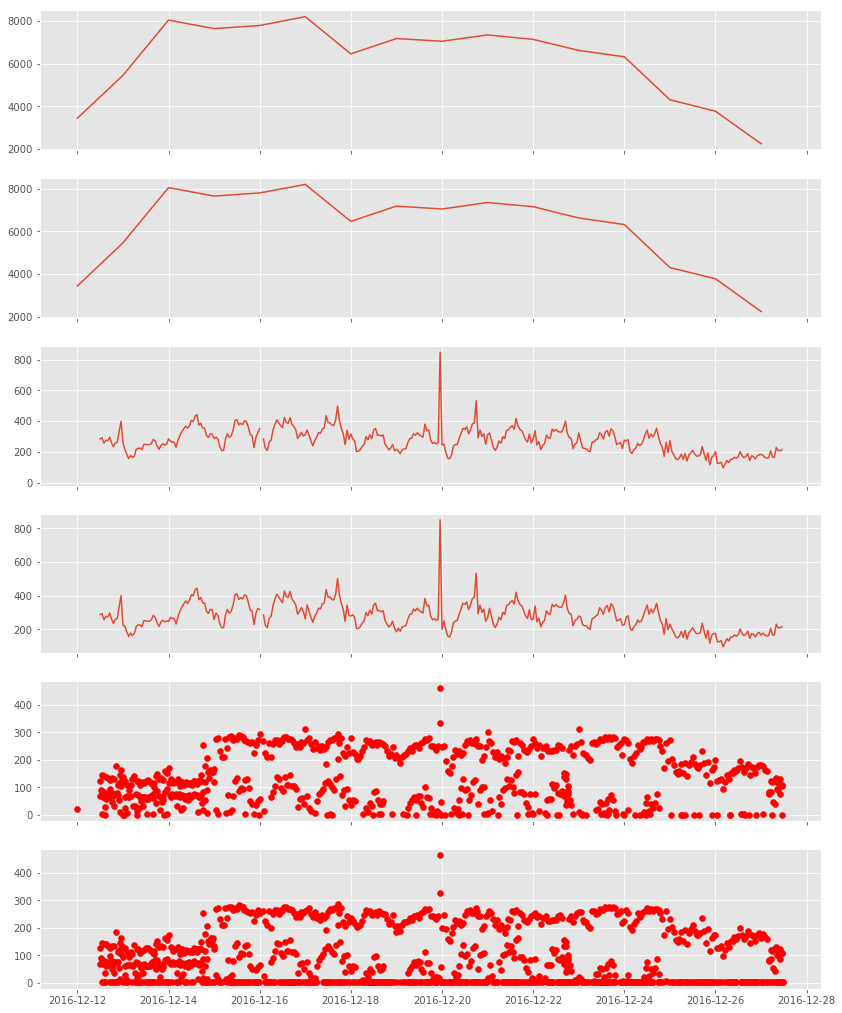

In [31]:
fig, axes = plt.subplots(6, figsize=(14,18), sharex=True)
axes[0].plot(global_daily)
axes[1].plot(global_c_daily)
axes[2].plot(global_hourly)
axes[3].plot(global_c_hourly)
axes[4].scatter(global_ten_mins.index, global_ten_mins.values, color="r")
axes[5].scatter(global_c_ten_mins.index, global_c_ten_mins.values, color="r")

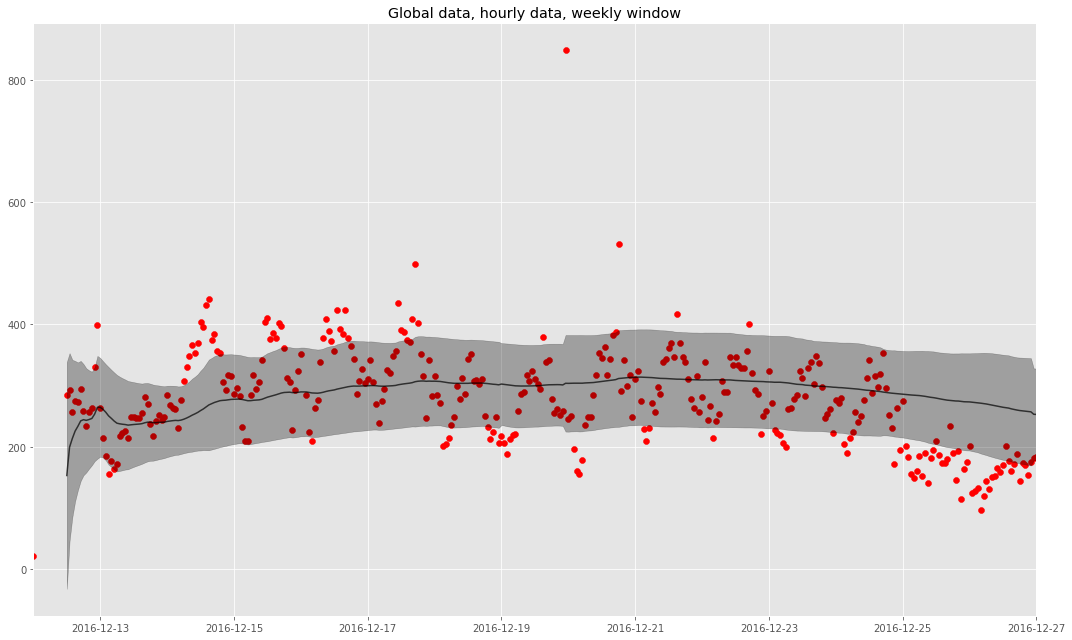

In [32]:
fig, ax = plt.subplots(1, figsize=(15,9))
plot_moving_std_trend(
    ax, 
    name="Global data, hourly data, weekly window", 
    data_series=global_hourly, 
    window=24*7
)
plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

## Unpacking Anomalies

In [127]:
def find_anomalies(series, window):
    rolling_std = fit_moving_std_trend(series, window=window)
    rolling_mean = fit_moving_average_trend(series, window=window)
    threshold = np.add(rolling_mean, rolling_std)
    anomalies = [point[0] if point[0] > point[1] else None for point in izip(series, threshold)]
    
    return pd.Series(anomalies, index=series.index)

def plot_anomalies(ax, 
                   anomalies_series,
                   name,
                   date_range=("2016-12-12","2016-12-27"), 
                   vline="2016-12-19 18:02:00"):
    ax.scatter(anomalies_series.index, anomalies_series.values)
    ax.set_xlim(date_range)
    ax.axvline(vline, color="b")
    ax.set_title(name)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Reports")

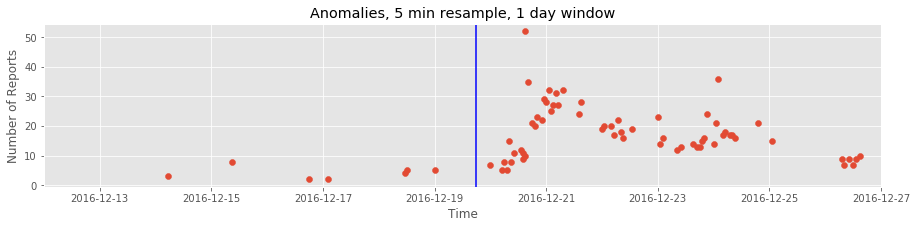

In [128]:
five_mins_anomalies = find_anomalies(five_mins, window=(24*60)/5)

fig, ax = plt.subplots(1, figsize=(15,3))

plot_anomalies(ax, five_mins_anomalies, name="Anomalies, 5 min resample, 1 day window")

In [129]:
one_min = ts.resample("T").sum()
two_mins = ts.resample("2T").sum()
three_mins = ts.resample("3T").sum()
four_mins = ts.resample("4T").sum()

resample_options = [one_min, two_mins, three_mins, four_mins, five_mins]

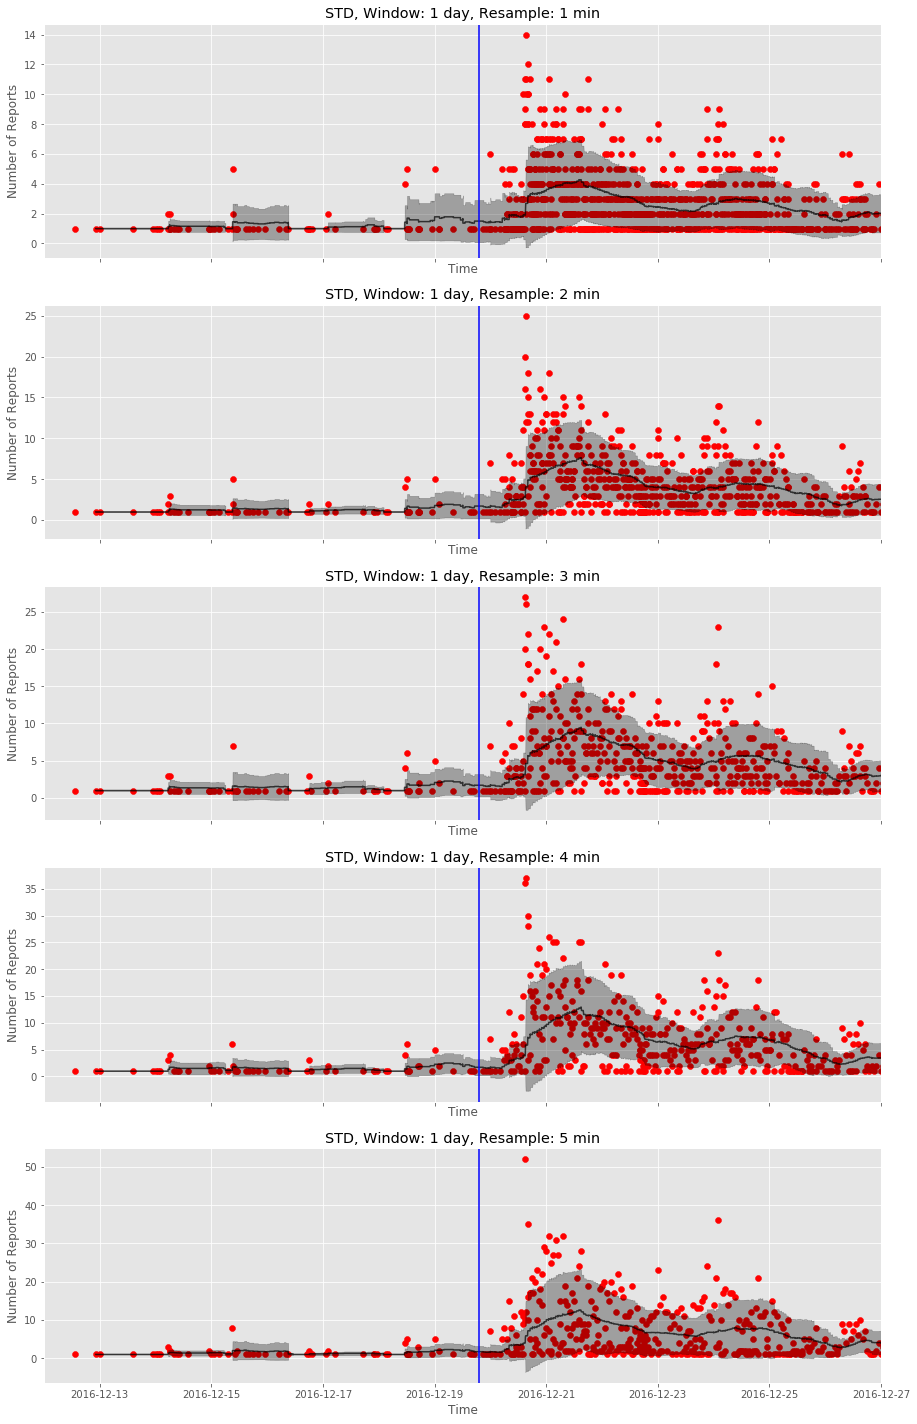

In [220]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for i, ax in enumerate(axes.flatten()):
    plot_moving_std_trend(
        ax,
        name="STD, Window: 1 day, Resample: {} min".format(i+1),
        data_series=resample_options[i],
        window=(24*60)/(i+1)
    )
    ax.axvline(attack_dtg, color="b")
    ax.set_xlim("2016-12-12","2016-12-27")
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Reports")



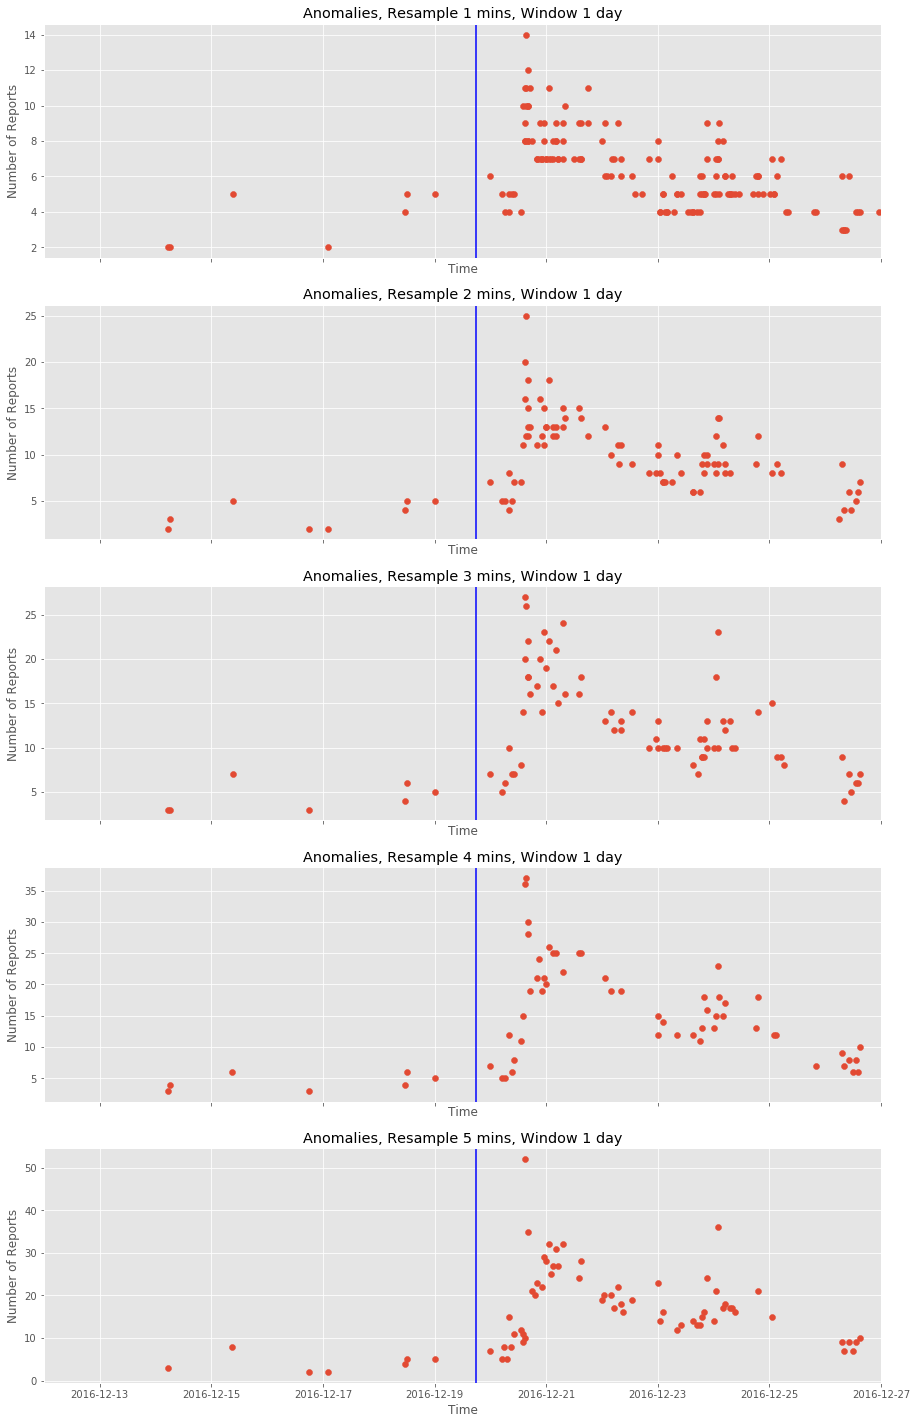

In [51]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for i, ax in enumerate(axes.flatten()):
    anomalies = find_anomalies(resample_options[i], window=(24*60)/(i+1))
    plot_anomalies(ax, anomalies, name="Anomalies, Resample {} mins, Window 1 day".format(i+1))
    

In [61]:
for i, resample in enumerate(resample_options):
    anomalies = find_anomalies(resample, window=(24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0}
    First Anomaly: {1}
    
    """.format(i+1, post_attack_anomalies.first_valid_index())
    


    Resample: 1
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 2
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 3
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 4
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 5
    First Anomaly: 2016-12-20 00:00:00
    
    


In [140]:
def severity_score(severity_rating):
    if severity_rating == "low":
        return 1
    elif severity_rating == "moderate":
        return 2
    elif severity_rating == "medium":
        return 3
    elif severity_rating == "high":
        return 4
    elif severity_rating == "extreme":
        return 5
    else:
        return 2

In [143]:
berlin_df["severity_score"] = berlin_df["severity"].map(severity_score)
print berlin_df.head()

           lat       lon                                              title  \
628   52.52437  13.41053   Berlin Borough prepping for planned power outage   
1027  52.52437  13.41053  Truck runs into crowded Christmas market in Be...   
1087  52.52437  13.41053  9 killed, 50 injured in Berlin in apparent tru...   
1124  52.52437  13.41053  Truck terror strikes Germany and European tourism   
1133  52.52437  13.41053  Truck crashed into Berlin market ‘intentionall...   

              created_on            start_ts  severity              lat_long  \
628  2016-12-16 05:08:54 2016-12-16 05:08:43  moderate  (52.52437, 13.41053)   
1027 2016-12-20 00:06:27 2016-12-20 00:06:15    medium  (52.52437, 13.41053)   
1087 2016-12-20 16:11:41 2016-12-20 16:11:30  moderate  (52.52437, 13.41053)   
1124 2016-12-20 23:07:32 2016-12-20 23:07:20  moderate  (52.52437, 13.41053)   
1133 2016-12-20 23:09:07 2016-12-20 23:08:56  moderate  (52.52437, 13.41053)   

        city  severity_score  
628   Berlin 

/Users/brendandorsey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [259]:
severity_ts = pd.Series(berlin_df["severity_score"].values, index=berlin_df["start_ts"])
# severity_ts = berlin_df["severity_score"]
# print severity_ts.shape
# print severity_ts.set_index(berlin_df["start_ts"])
# print severity_ts.first_valid_index()

In [260]:
sev_one_min = severity_ts.resample("T").sum()
sev_two_mins = severity_ts.resample("2T").sum()
sev_three_mins = severity_ts.resample("3T").sum()
sev_four_mins = severity_ts.resample("4T").sum()
sev_five_mins = severity_ts.resample("5T").sum()

sev_resample_options = [sev_one_min, sev_two_mins, sev_three_mins, sev_four_mins, sev_five_mins]

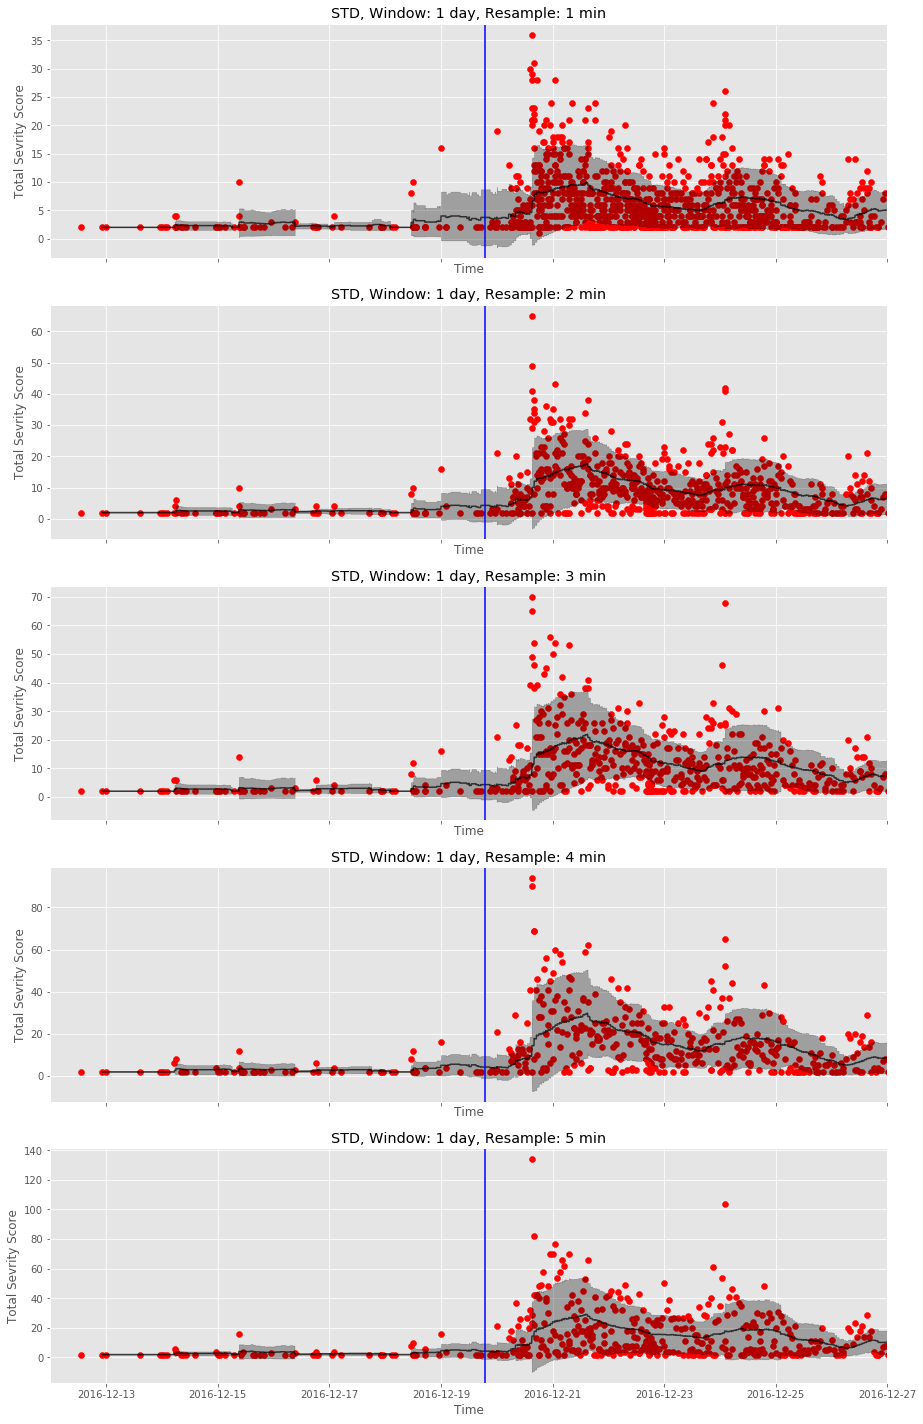

In [263]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for idx, ax in enumerate(axes.flatten()):
    plot_moving_std_trend(
        ax,
        name="STD, Window: 1 day, Resample: {} min".format(idx+1),
        data_series=sev_resample_options[idx],
        window=24*60/(idx+1)
    )
    ax.axvline(attack_dtg, color="b")
    ax.set_xlim("2016-12-12","2016-12-27")
    ax.set_xlabel("Time")
    ax.set_ylabel("Total Sevrity Score")

In [262]:
def severity_score_quadratic(severity_rating):
    if severity_rating == "low":
        return 1
    elif severity_rating == "moderate":
        return 4
    elif severity_rating == "medium":
        return 9
    elif severity_rating == "high":
        return 16
    elif severity_rating == "extreme":
        return 25
    else:
        return 4

In [265]:
berlin_df["severity_quadratic"] = berlin_df["severity"].map(severity_score_quadratic)
quadratic_ts = pd.Series(berlin_df["severity_quadratic"].values, index=berlin_df["start_ts"])

quad_one_min = quadratic_ts.resample("T").sum()
quad_two_min = quadratic_ts.resample("2T").sum()
quad_three_min = quadratic_ts.resample("3T").sum()
quad_four_min = quadratic_ts.resample("4T").sum()
quad_five_min = quadratic_ts.resample("5T").sum()

quad_resample_options = [quad_one_min, quad_two_min, quad_three_min, quad_four_min, quad_five_min]

/Users/brendandorsey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


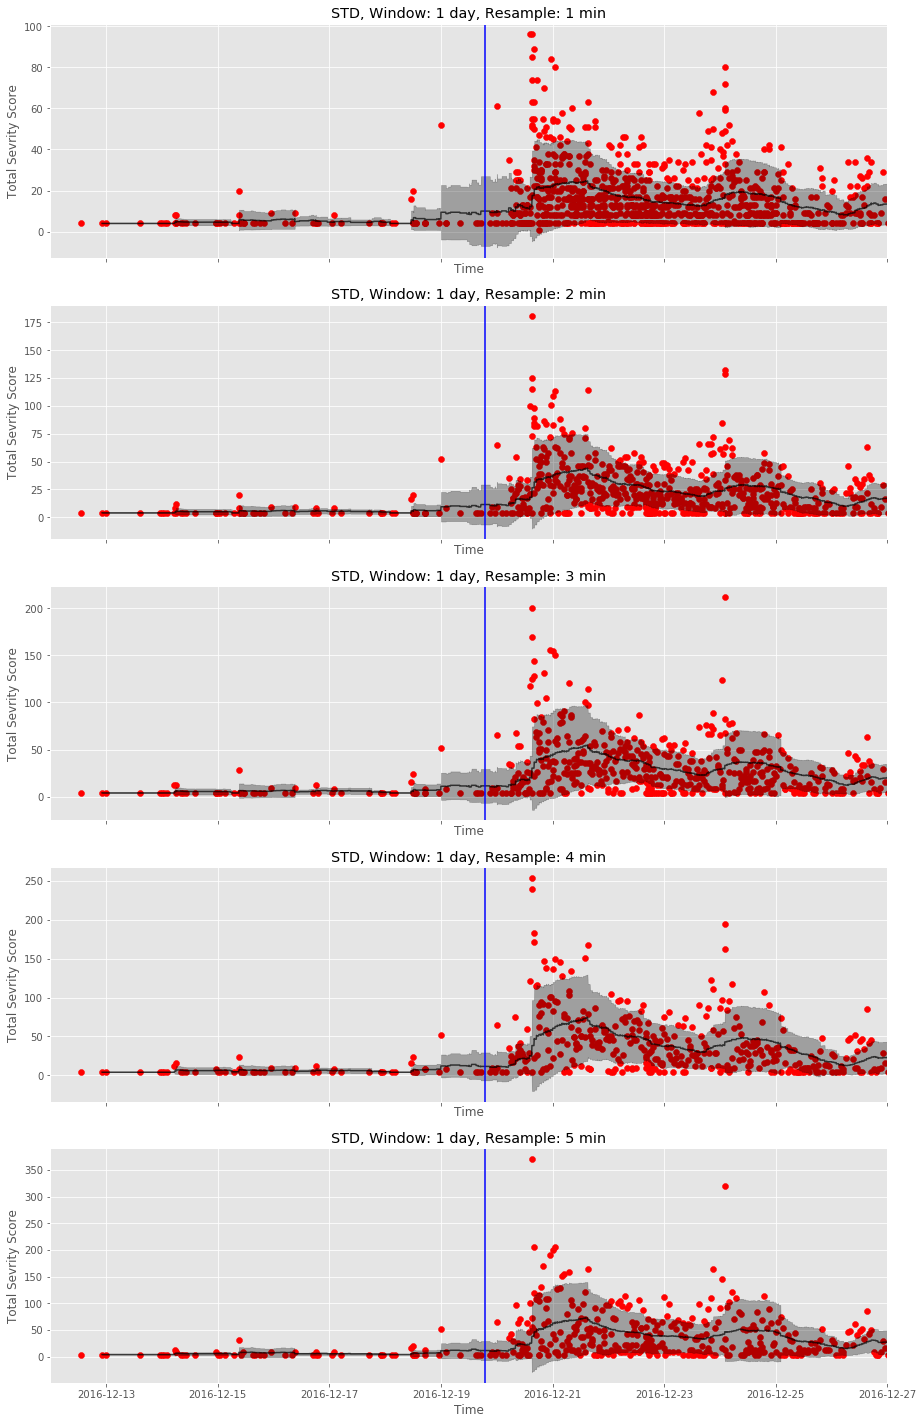

In [266]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for idx, ax in enumerate(axes.flatten()):
    plot_moving_std_trend(
        ax,
        name="STD, Window: 1 day, Resample: {} min".format(idx+1),
        data_series=quad_resample_options[idx],
        window=24*60/(idx+1)
    )
    ax.axvline(attack_dtg, color="b")
    ax.set_xlim("2016-12-12","2016-12-27")
    ax.set_xlabel("Time")
    ax.set_ylabel("Total Sevrity Score")

In [267]:
for i, resample in enumerate(quad_resample_options):
    anomalies = find_anomalies(resample, window=(24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0}
    First Anomaly: {1}
    
    """.format(i+1, post_attack_anomalies.first_valid_index())


    Resample: 1
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 2
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 3
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 4
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 5
    First Anomaly: 2016-12-20 00:00:00
    
    


In [268]:
for i, resample in enumerate(sev_resample_options):
    anomalies = find_anomalies(resample, window=(24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0}
    First Anomaly: {1}
    
    """.format(i+1, post_attack_anomalies.first_valid_index())


    Resample: 1
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 2
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 3
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 4
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 5
    First Anomaly: 2016-12-20 00:00:00
    
    
